# 12 - Implementation of time blocking for compression/serialization and de-serialization/de-compression of wavefields with Devito operators

## Introduction 

The goal of this tutorial is to prototype the compression/serialization and de-serialization/de-compression for wavefields in Devito. The motivation is using seismic modeling operators for full waveform inversion (FWI). Some of the steps in FWI require the use of previously computed wavefields, and of particular interest the adjoint of the Jacobian linearized operator -- an operator that maps data perturbation into velocity perturbation and is used to build FWI gradients -- requires a zero-lag temporal correlation with the wavefield that is computed with the nonlinear source. 

There are implemented alternatives to serialization/de-serialization like checkpointing, but we investigate the serialization option here. For more information on checkpointing, please see the details for ```pyrevolve```, a python implementation of `optimal checkpointing` for Devito (https://github.com/devitocodes/pyrevolve).

We aim to provide a *proof of concept* for compression/serialization and de-serialization/de-compression of the nonlinear wavefield. We will achieve this via _time blocking_: we will run a number of time steps in the generated c kernel, and then return control to Python for compression/serialization (for the nonlinear forward operator), and de-serialization/de-compression (for the linearized Jacobian forward and adjoint operators).

In order to illustrate the use case for serialization, we outline the workflow for computing the gradient of the FWI objective function, ignoring a lot of details, as follows:

1. Generate the nonlinear forward modeled data at the receivers $d_{mod}$
$$ 
d_{mod} = F m 
$$

1. Compress and serialize the nonlinear source wavefield to disk in *time blocks* during computation of 1. The entire nonlinear wavefield is of size $[nt,nx,nz]$ in 2D, but we deal with a block of $M$ time steps at a time, so the size of the chunk to be compressed and serialized is $[M,nx,nz]$. 

1. Compute the data residual $\delta r$ by differencing observed and modeled data at the receivers 
$$
\delta r = d_{obs} - d_{mod}
$$

1. Backproject the data residual $\delta r$ via time reversal with the adjoint linearized Jacobian operator.

1. De-serialize and de-compress the nonlinear source wavefield from disk during computation in step 4, synchronizing time step between the nonlinear wavefield computed forward in time, and time reversed adjoint wavefield. We will deal with de-serialization and de-compression of chunks of $M$ time steps of size $[M,nx,nz]$.

1. Increment the model perturbation via zero lag correlation of the de-serialized nonlinear source wavefield and the backprojected receiver adjoint wavefield. Note that this computed model perturbation is the  _gradient_ of the FWI objective function.
$$
\delta m = \bigl( \nabla F\bigr)^\top\ \delta r
$$

Please see other notebooks in the `seismic/self=adjoint` directory for more details, in particular the notebooks describing the self-adjoint modeling operators. 

| Self-adjoint notebook description | name | 
|:---|:---|
| Nonlinear operator | `sa_01_iso_implementation1.ipynb` |
| Jacobian linearized operators | `sa_02_iso_implementation2.ipynb` |
| Correctness tests | `sa_03_iso_correctness.ipynb` |

## Outline 
1. Definition of symbols
1. Description of tests to verify correctness
1. Description of time blocking implementation
1. Compression note -- use of ```blosc```
1. Create small 2D test model
1. Implement and test the Nonlinear forward operation
  - Save all time steps 
  - Time blocking plus compression/serialization
  - Ensure differences are at machine epsilon 
1. Implement and test the Jacobian linearized forward operation
  - Save all time steps 
  - Time blocking plus compression/serialization
  - Ensure differences are at machine epsilon 
1. Implement and test the Jacobian linearized adjoint operation
  - Save all time steps 
  - Time blocking plus compression/serialization
  - Ensure differences are at machine epsilon 
1. Discussion

## Table of symbols

We show the symbols here relevant to the implementation of the linearized operators.

| Symbol &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | Description  | Dimensionality | 
|:---|:---|:---|
| $m_0(x,y,z)$ | Reference P wave velocity    | function of space |
| $\delta m(x,y,z)$ | Perturbation to P wave velocity    | function of space |
| $u_0(t,x,y,z)$ | Reference pressure wavefield | function of time and space |
| $\delta u(t,x,y,z)$ | Perturbation to pressure wavefield | function of time and space |
| $q(t,x,y,z)$ | Source wavefield | function of time, localized in space to source location |
| $r(t,x,y,z)$ | Receiver wavefield | function of time, localized in space to receiver locations |
| $\delta r(t,x,y,z)$ | Receiver wavefield perturbation | function of time, localized in space to receiver locations |
| $F[m; q]$ | Forward nonlinear modeling operator | Nonlinear in $m$, linear in $q$: $\quad$ maps $m \rightarrow r$ |
| $\nabla F[m; q]\ \delta m$ | Forward Jacobian modeling operator | Linearized at $[m; q]$: $\quad$ maps $\delta m \rightarrow \delta r$ |
| $\bigl( \nabla F[m; q] \bigr)^\top\ \delta r$ | Adjoint Jacobian modeling operator | Linearized at $[m; q]$: $\quad$ maps $\delta r \rightarrow \delta m$ |

## Description of tests to verify correctness

In order to make sure we have implemented the time blocking correctly, we numerically compare the output from two runs:
1. all time steps saved implementation -- requires a lot of memory to hold wavefields at each time step
1. time blocking plus compression/serialization implementation -- requires only enough memory to hold the wavefields in a time block  

We perform these tests for three phases of FWI modeling:
1. nonlinear forward: maps model to data, *forward in time*
1. Jacobian linearized forward: maps model perturbation to data perturbation, *forward in time*
1. Jacobian linearized adjoint: maps data perturbation to model perturbation, *backward in time*

We will design a small 2D test experiment with a source in the middle of the model and short enough elapsed modeling time that we do not need to worry about boundary reflections for these tests, or runnin out of memory saving all time steps.

## Description of time blocking implementation

We gratefully acknowledge Downunder Geosolutions (DUG) for in depth discussions about their production time blocking implementation. Those discussions shaped the implementation shown here. The most important idea is to separate the programmatic containers used for propagation and serialization. To do this we utilize two distinct ```TimeFunction```'s.

### Propagation uses ```TimeFunction(..., save=None)```

We use a default constructed ```TimeFunction``` for propagation. This can be specified in the constructor via either ```save=None``` or no ```save``` argument at all. Devito backs such a default ```TimeFunction``` by a ```Buffer``` of size ```time_order+1```, or 3 for second order in time. We show below the mapping from the monotonic *ordinary time indices* to the buffered *modulo time indices* as used by a ```Buffer``` in a ```TimeFuntion``` with ```time_order=2```.

### Modulo indexing for ```Buffer``` of size 3
```
Ordinary time indices:  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15
Modulo   time indices:  0  1  2  0  1  2  0  1  2  0  1  2  0  1  2  0
```

*Important note:* the modulo indexing of ```Buffer``` is the reason we will separate propagation from serialization. If we use a larger ```Bufffer``` as the ```TimeFunction``` for propagation, we would have to deal with the modulo indexing not just for the current time index, but also previous and next time indices (assuming second order in time). This means that the previous and next time steps can overwrite the locations of the ordinary time indices when you propagate for a block of time steps. **This is the reason we do not use the same ```TimeFunction``` for both propagation and serialization.**

### Generated code for a second order in time PDE
We now show an excerpt from Devito generated code for a second order in time operator. A second order in time PDE requires two wavefields in order to advance in time: the wavefield at the next time step $u(t+\Delta t)$ is a function of the wavefield at previous time step $u(t-\Delta t)$ and the wavefield at the current time step $u(t)$. Remember that Devito uses a ```Buffer``` of size 3 to handle this. 

In the generated code there are three modulo time indices that are a function of ordinary time and cycle through the values $[0,1,2]$:
* ```t0``` -- current time step
* ```t1``` -- next time step
* ```t2``` -- previous time step

We show an excerpt at the beginning of the time loop from the generated code below, with ordinary time loop index ```time```. Note that we have simplified the generated code by breaking a single for loop specification line into multiple lines for clarity. We have also added comments to help understand the mapping from ordinary to modulo time indices.

```
for (int time = time_m; time <= time_M; time += 1) {
  t0 = (time + 0)%(3);    // time index for the current time step 
  t1 = (time + 1)%(3);    // time index for the next time step
  t2 = (time + 2)%(3);    // time index for the  previous time step
  
  // ... PIE: propagation, source injection, receiver extraction ...
}

```

It should be obvious that using a single container for both propagation and serialization is problematic because the loop runs over ordinary time indices ```time_m``` through ```time_M```, but will access stored previous time step wavefields at indices ```time_m-1``` through ```time_M-1``` and store computed next time step wavefields in indices ```time_m+1``` through ```time_M+1```. 

### Serialization uses ```TimeFunction(..., save=Buffer(M))``` 

We will use an independent second ```Buffer``` of size $M$ for serialization in our time blocking implementation. This second ```TimeFunction``` will also use modulo indexing, but by design we only access indices ```time_m``` through ```time_M``` in each time block. This means we do not need to worry about wrapping indices from previous time step or next time step wavefields.

### Minimum and maximum allowed time index for second order PDE

It is important to note that for a second order in time system the minimum allowed time index ```time_m``` will be $1$, because time index $0$ would imply that the previous time step wavefield $u(t-\Delta t)$ exists at time index $-1$, and $0$ is the minimum array location.

Similarly, the maximum allowed time index ```time_M``` will be $nt-2$, because time index $nt-1$ would imply that the next time step wavefield $u(t+\Delta t)$ exists at time index $nt$, and $nt-1$ is the maximum array location.

### Flow charts for time blocking

Putting this all together, here are flow charts outlining control flow the first two time blocks with $M=5$.

#### Time blocking for the nonlinear forward

```
Time block 1
    Call generated code Operator(time_m=1, time_M=5)
	Return control to Python
    Compress indices 1,2,3,4,5
    Serialize indices 1,2,3,4,5 
        (access modulo indices 1%5,2%5,3%5,4%5,5%5)

Time block 2
    Call generated code Operator(time_m=6, time_M=10)
	Return control to Python
    Compress indices 6,7,8,9,10
    Serialize indices 6,7,8,9,10
        (access modulo indices 6%5,7%5,8%5,9%5,10%5)
```

#### Time blocking for the linearized Jacobian adjoint (time reversed)

```
Time block 2
    De-serialize indices 6,7,8,9,10
    De-compress indices 6,7,8,9,10
        (access modulo indices 6%5,7%5,8%5,9%5,10%5)
    Call generated code Operator(time_m=6, time_M=10)
	Return control to Python

Time block 1
    De-serialize indices 1,2,3,4,5 
    De-compress indices 1,2,3,4,5
        (access modulo indices 1%5,2%5,3%5,4%5,5%5)
    Call generated code Operator(time_m=1, time_M=5)
	Return control to Python
```

## Arrays used to save file offsets and compressed sizes

We use two arrays the length of the total number of time steps to save bookeeping information used for the serialization and compression. During de-serialization these offsets and lengths will be used to seek the correct location and read the correct length from the binary file saving the compressed data.

| Array | Description |
|:---|:---|
| file_offset | stores the location of the start of the compressed block for each time step | 
| file_length | stores the length of the compressed block for each time step | 


## Compression note -- use of ```blosc```

In this notebook we use ```blosc``` compression that is not loaded by default in devito. The first operational cell immediately below ensures that  ```blosc``` compression and Python wrapper are installed in this jupyter kernel. 

Note that ```blosc``` provides *lossless compression*, and in practice one would use *lossy compression* to achieve significantly better compression ratios. Consider the use of ```blosc``` here as a placeholder for your compression method of choice, providing all the essential characteristics of what might be used at scale. 

We will use the low level interface to blosc compression because it allows the easiest use of numpy arrays. A synopsis of the compression and decompression calls is shown below for devito ```TimeFunction``` $u$, employing compression level $9$ of the ```zstd``` type with the optional shuffle, at modulo time index ```kt%M```.

```
    c = blosc.compress_ptr(u._data[kt%M,:,:].__array_interface__['data'][0], 
                           np.prod(u2._data[kt%M,:,:].shape), 
                           u._data[kt%M,:,:].dtype.itemsize, 9, True, 'zstd')
    
    blosc.decompress_ptr(u._data[kt,:,:], d.__array_interface__['data'][0])
```

```blosc``` Reference:
* c project and library: https://blosc.org
* Python wrapper: https://github.com/Blosc/python-blosc
* Python wrapper documentation: http://python-blosc.blosc.org
* low level interface to compression call: http://python-blosc.blosc.org/tutorial.html#compressing-from-a-data-pointer

In [1]:
# NBVAL_IGNORE_OUTPUT

# Install pyzfp package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install blosc
import blosc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/2.6 MB ? eta -:--:--

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 23.0 MB/s eta 0:00:00


## Imports 

We have grouped all imports used in this notebook here for consistency.

In [2]:
import numpy as np
from examples.seismic import RickerSource, Receiver, TimeAxis
from devito import (Grid, Function, TimeFunction, SpaceDimension, Constant, 
                    Eq, Operator, configuration, norm, Buffer)
from examples.seismic.self_adjoint import setup_w_over_q
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import copy
import os

# These lines force images to be displayed in the notebook, and scale up fonts 
%matplotlib inline
mpl.rc('font', size=14)

# Make white background for plots, not transparent
plt.rcParams['figure.facecolor'] = 'white'

# Set logging to debug, captures statistics on the performance of operators
# configuration['log-level'] = 'DEBUG'
configuration['log-level'] = 'INFO'

## Instantiate the model for a two dimensional problem
We are aiming at a small model as this is a POC.
 - 101 x 101 cell model 
 - 20x20 m discretization 
 - Modeling sample rate explicitly chosen: 2.5 msec
 - Time range 250 milliseconds (101 time steps)
 - Wholespace model
   - velocity: 1500 m/s
   - density: 1 g/cm^3
 - Source to left of center 
 - Vertical line of receivers to right of center 
 - Velocity perturbation box for linearized ops in center of model
 - Visco-acoustic absorbing boundary from the self-adjoint operators linked above, 10 points on exterior boundaries.
 - We generate a velocity perturbation for the linearized forward Jacobian operator

In [3]:
# NBVAL_IGNORE_OUTPUT

# Define dimensions for the interior of the model
nx,nz = 101,101
npad = 10
dx,dz = 20.0,20.0  # Grid spacing in m
shape = (nx, nz)   # Number of grid points
spacing = (dx, dz) # Domain size is now 5 km by 5 km
origin = (0., 0.)  # Origin of coordinate system, specified in m.
extent = tuple([s*(n-1) for s, n in zip(spacing, shape)])

# Define the dimensions 
x = SpaceDimension(name='x', spacing=Constant(name='h_x', value=extent[0]/(shape[0]-1)))
z = SpaceDimension(name='z', spacing=Constant(name='h_z', value=extent[1]/(shape[1]-1)))

# Initialize the Devito grid 
dtype = np.float32
grid = Grid(extent=extent, shape=shape, origin=origin, dimensions=(x, z), dtype=dtype)

print("shape;           ", shape)
print("origin;          ", origin)
print("spacing;         ", spacing)
print("extent;          ", extent)

print("")
print("grid.shape;      ", grid.shape)
print("grid.extent;     ", grid.extent)
print("grid.spacing_map;", grid.spacing_map)

# Create velocity and buoyancy fields. 
space_order = 8
m0 = Function(name='m0', grid=grid, space_order=space_order)
b = Function(name='b', grid=grid, space_order=space_order)
m0.data[:] = 1.5
b.data[:,:] = 1.0 / 1.0

# Perturbation to velocity: a square offset from the center of the model
dm = Function(name='dm', grid=grid, space_order=space_order)
size = 4
x0 = (nx-1)//2 + 1
z0 = (nz-1)//2 + 1
dm.data[:] = 0.0
dm.data[(x0-size):(x0+size+1), (z0-size):(z0+size+1)] = 1.0

# Initialize the attenuation profile for the absorbing boundary
fpeak = 0.001
w = 2.0 * np.pi * fpeak
qmin = 0.1
wOverQ = Function(name='wOverQ_025', grid=grid, space_order=space_order)
setup_w_over_q(wOverQ, w, qmin, 100.0, npad)

# Time sampling
t0 = 0    # Simulation time start
tn = 250  # Simulation time end
dt = 2.5  # Simulation time step interval
time_range = TimeAxis(start=t0, stop=tn, step=dt)
nt = time_range.num
print("")
print("time_range; ", time_range)

# Source 10 Hz center frequency
src = RickerSource(name='src', grid=grid, f0=fpeak, npoint=1, time_range=time_range)
src.coordinates.data[0,:] = [dx * ((nx-1) / 2 - 10), dz * (nz-1) / 2]

# Receivers: for nonlinear forward and linearized forward
# one copy each for save all and time blocking implementations
nr = 51
z1 = dz * ((nz - 1) / 2 - 40)
z2 = dz * ((nz - 1) / 2 + 40)

nl_rec1 = Receiver(name='nl_rec1', grid=grid, npoint=nr, time_range=time_range)
nl_rec2 = Receiver(name='nl_rec2', grid=grid, npoint=nr, time_range=time_range)
ln_rec1 = Receiver(name='ln_rec1', grid=grid, npoint=nr, time_range=time_range)
ln_rec2 = Receiver(name='ln_rec2', grid=grid, npoint=nr, time_range=time_range)
nl_rec1.coordinates.data[:,0] = nl_rec2.coordinates.data[:,0] = \
    ln_rec1.coordinates.data[:,0] = ln_rec2.coordinates.data[:,0] = dx * ((nx-1) / 2 + 10)
nl_rec1.coordinates.data[:,1] = nl_rec2.coordinates.data[:,1] = \
    ln_rec1.coordinates.data[:,1] = ln_rec2.coordinates.data[:,1] = np.linspace(z1, z2, nr)

print("")
print("src_coordinate  X;         %+12.4f" % (src.coordinates.data[0,0]))
print("src_coordinate  Z;         %+12.4f" % (src.coordinates.data[0,1]))
print("rec_coordinates X min/max; %+12.4f %+12.4f" % \
      (np.min(nl_rec1.coordinates.data[:,0]), np.max(nl_rec1.coordinates.data[:,0])))
print("rec_coordinates Z min/max; %+12.4f %+12.4f" % \
      (np.min(nl_rec1.coordinates.data[:,1]), np.max(nl_rec1.coordinates.data[:,1])))

shape;            (101, 101)
origin;           (0.0, 0.0)
spacing;          (20.0, 20.0)
extent;           (2000.0, 2000.0)

grid.shape;       (101, 101)
grid.extent;      (np.float32(2000.0), np.float32(2000.0))
grid.spacing_map; {h_x: np.float32(20.0), h_z: np.float32(20.0)}


Operator `WOverQ_Operator` ran in 0.01 s



time_range;  TimeAxis: start=0, stop=250, step=2.5, num=101

src_coordinate  X;            +800.0000
src_coordinate  Z;           +1000.0000
rec_coordinates X min/max;   +1200.0000   +1200.0000
rec_coordinates Z min/max;    +200.0000   +1800.0000


## Plot velocity and density models

Next we plot the velocity and density models for illustration, with source location shown as a large red asterisk and receiver line shown as a black line.

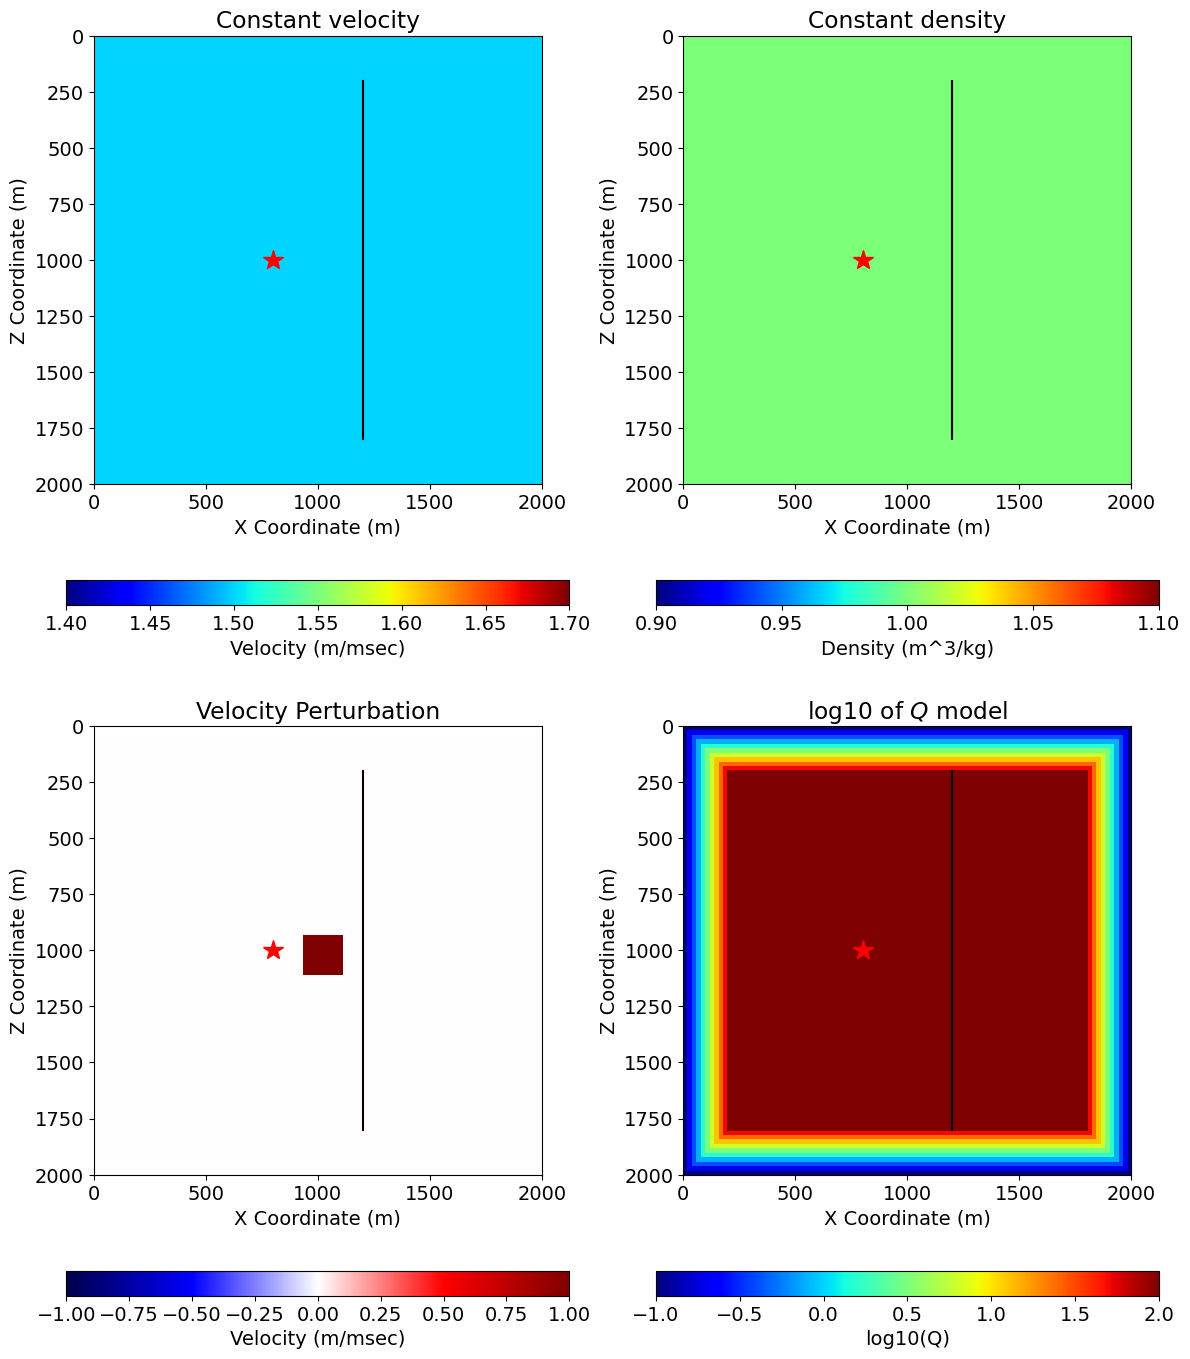

In [4]:
#NBVAL_IGNORE_OUTPUT
# note: flip sense of second dimension to make the plot positive downwards
plt_extent = [origin[0], origin[0] + extent[0], origin[1] + extent[1], origin[1]]

vmin, vmax = 1.4, 1.7
pmin, pmax = -1, +1
dmin, dmax = 0.9, 1.1

plt.figure(figsize=(12,14))

# plot velocity 
plt.subplot(2, 2, 1)
plt.imshow(np.transpose(m0.data), cmap=cm.jet, 
           vmin=vmin, vmax=vmax, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Velocity (m/msec)')
plt.plot(nl_rec1.coordinates.data[:, 0], nl_rec1.coordinates.data[:, 1], \
         'black', linestyle='-', label="Receiver")
plt.plot(src.coordinates.data[:, 0], src.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Constant velocity")

# plot density
plt.subplot(2, 2, 2)
plt.imshow(np.transpose(1 / b.data), cmap=cm.jet,
           vmin=dmin, vmax=dmax, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Density (m^3/kg)')
plt.plot(nl_rec1.coordinates.data[:, 0], nl_rec1.coordinates.data[:, 1], \
         'black', linestyle='-', label="Receiver")
plt.plot(src.coordinates.data[:, 0], src.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Constant density")

# plot velocity perturbation
plt.subplot(2, 2, 3)
plt.imshow(np.transpose(dm.data), cmap="seismic", 
           vmin=pmin, vmax=pmax, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Velocity (m/msec)')
plt.plot(nl_rec1.coordinates.data[:, 0], nl_rec1.coordinates.data[:, 1], \
         'black', linestyle='-', label="Receiver")
plt.plot(src.coordinates.data[:, 0], src.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Velocity Perturbation")

# Plot the log of the generated Q profile
q = np.log10(w / wOverQ.data)
lmin, lmax = np.log10(qmin), np.log10(100)

plt.subplot(2, 2, 4)
plt.imshow(np.transpose(q.data), cmap=cm.jet, vmin=lmin, vmax=lmax, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='log10(Q)')
plt.plot(nl_rec1.coordinates.data[:, 0], nl_rec1.coordinates.data[:, 1], \
         'black', linestyle='-', label="Receiver")
plt.plot(src.coordinates.data[:, 0], src.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("log10 of $Q$ model")

plt.tight_layout()
None

## Implementation of the nonlinear forward

We copy the nonlinear forward PDE described in the 1st self-adjoint notebook linked above:

$$
L_t[\cdot] \equiv \frac{\omega_c}{Q} \overleftarrow{\partial_t}[\cdot] + \partial_{tt}[\cdot]
$$

$$
\frac{b}{m^2} L_t[u] =
    \overleftarrow{\partial_x}\left(b\ \overrightarrow{\partial_x}\ u \right) +
    \overleftarrow{\partial_y}\left(b\ \overrightarrow{\partial_y}\ u \right) +
    \overleftarrow{\partial_z}\left(b\ \overrightarrow{\partial_z}\ u \right) + q
$$

## Quantity that is serialized 

Recall that for Jacobian operators we need the scaled time derivatives of the reference wavefield for both the Born source in the Jacobian forward, and the imaging condition in the Jacobian adjoint. The quantity shown below is used in those expressions, and this is what we will serialize and compress during the nonlinear forward.

$$
\frac{2\ b}{m_0}\ L_t[u_0] 
$$

## The two implementations

We borrow the stencil from the self-adjoint operators shown in the jupyter notebooks linked above, and make two operators. Here are details about the configuration.

### Save all time steps implementation
  * wavefield for propagation: ```u1 = TimeFunctions(..., save=None)```
  * wavefield for serialization: ```v1 = TimeFunctions(..., save=nt)```
  * Run the operator in a single execution from ```time_m=1``` to ```time_M=nt-1```

### Time blocking implementation
  * wavefield for propagation: ```u2 = TimeFunctions(..., save=None)```
  * wavefield for serialization: ```v2 = TimeFunctions(..., save=Buffer(M))```
  * Run the operator in a sequence of time blocks, each with $M$ time steps, from ```time_m=1``` to ```time_M=nt-1```
  
## Note on code duplication

The stencils for the two operators you see below are exactly the same, the only significant difference is that we use two different ```TimeFunction```s. We could therefore reduce code duplication in two ways:

1. Use the placeholder design pattern and ```stencil.subs``` to substitude the appropriate ```TimeFunction```. 
Please see the FAQ for more information [https://github.com/devitocodes/devito/wiki/FAQ#how-are-abstractions-used-in-the-seismic-examples](https://github.com/devitocodes/devito/wiki/FAQ#how-are-abstractions-used-in-the-seismic-examples)

2. Write a function and use it to build the stencils.

To increase the clarity of the exposition below, We do neither of these and duplicate the stencil code.

In [5]:
# NBVAL_IGNORE_OUTPUT

# Define M: number of time steps in each time block
M = 5

# Create TimeFunctions
u1 = TimeFunction(name="u1", grid=grid, time_order=2, space_order=space_order, save=None)
u2 = TimeFunction(name="u2", grid=grid, time_order=2, space_order=space_order, save=None)
v1 = TimeFunction(name="v1", grid=grid, time_order=2, space_order=space_order, save=nt)
v2 = TimeFunction(name="v2", grid=grid, time_order=2, space_order=space_order, save=Buffer(M))

# get time and space dimensions 
t,x,z = u1.dimensions

# Source terms (see notebooks linked above for more detail)
src1_term = src.inject(field=u1.forward, expr=src * t.spacing**2 * m0**2 / b)
src2_term = src.inject(field=u2.forward, expr=src * t.spacing**2 * m0**2 / b)
nl_rec1_term = nl_rec1.interpolate(expr=u1.forward)
nl_rec2_term = nl_rec2.interpolate(expr=u2.forward)

# The nonlinear forward time update equation
update1 = (t.spacing**2 * m0**2 / b) * \
    ((b * u1.dx(x0=x+x.spacing/2)).dx(x0=x-x.spacing/2) + \
     (b * u1.dz(x0=z+z.spacing/2)).dz(x0=z-z.spacing/2)) + \
    (2 - t.spacing * wOverQ) * u1 + \
    (t.spacing * wOverQ - 1) * u1.backward

update2 = (t.spacing**2 * m0**2 / b) * \
    ((b * u2.dx(x0=x+x.spacing/2)).dx(x0=x-x.spacing/2) + \
     (b * u2.dz(x0=z+z.spacing/2)).dz(x0=z-z.spacing/2)) + \
    (2 - t.spacing * wOverQ) * u2 + \
    (t.spacing * wOverQ - 1) * u2.backward

stencil1 = Eq(u1.forward, update1)
stencil2 = Eq(u2.forward, update2)

# Equations for the Born term
v1_term = Eq(v1, (2 * b * m0**-3) * (wOverQ * u1.dt(x0=t-t.spacing/2) + u1.dt2))
v2_term = Eq(v2, (2 * b * m0**-3) * (wOverQ * u2.dt(x0=t-t.spacing/2) + u2.dt2))

# Update spacing_map (see notebooks linked above for more detail)
spacing_map = grid.spacing_map
spacing_map.update({t.spacing : dt})

# Build the Operators
nl_op1 = Operator([stencil1, src1_term, nl_rec1_term, v1_term], subs=spacing_map)
nl_op2 = Operator([stencil2, src2_term, nl_rec2_term, v2_term], subs=spacing_map)

# Run operator 1 for all time samples
u1.data[:] = 0
v1.data[:] = 0
nl_rec1.data[:] = 0
nl_op1(time_m=1, time_M=nt-2)

None

Operator `Kernel` ran in 0.01 s


In [6]:
# NBVAL_IGNORE_OUTPUT

# Continuous integration hooks for the save all timesteps implementation
# We ensure the norm of these computed wavefields is repeatable
print("%.3e" % norm(u1))
print("%.3e" % norm(nl_rec1))
print("%.3e" % norm(v1))
assert np.isclose(norm(u1), 4.145e+01, atol=0, rtol=1e-3)
assert np.isclose(norm(nl_rec1), 2.669e-03, atol=0, rtol=1e-3)
assert np.isclose(norm(v1), 1.381e-02, atol=0, rtol=1e-3)

4.145e+01
2.669e-03


1.381e-02


### Run the time blocking implementation over blocks of M time steps

After each block of $M$ time steps, we return control to Python to extract the Born term and serialize/compress. 

The next cell exercises the time blocking operator over $N$ time blocks. 

In [7]:
# NBVAL_IGNORE_OUTPUT

# We make an array the full size for correctness testing
v2_all = np.zeros(v1.data.shape, dtype=dtype)

# Number of time blocks
N = int((nt-1) / M) + 1

# Open a binary file in append mode to save the wavefield chunks  
filename = "timeblocking.nonlinear.bin"

if os.path.exists(filename):
    os.remove(filename)
f = open(filename, "ab")

# Arrays to save offset and length of compressed data
file_offset = np.zeros(nt, dtype=np.int64)
file_length = np.zeros(nt, dtype=np.int64)

# The length of the data type, 4 bytes for float32
itemsize = v2.data[0,:,:].dtype.itemsize 

# The length of a an uncompressed wavefield, used to compute compression ratio below
len0 = 4.0 * np.prod(v2._data[0,:,:].shape)

# Loop over time blocks
v2_all[:] = 0
u2.data[:] = 0
v2.data[:] = 0
nl_rec2.data[:] = 0
for kN in range(0,N,1):
    kt1 = max((kN + 0) * M, 1)
    kt2 = min((kN + 1) * M - 1, nt-2)
    nl_op2(time_m=kt1, time_M=kt2)

    # Copy computed Born term for correctness testing
    for kt in range(kt1,kt2+1):

        # assign
        v2_all[kt,:,:] = v2.data[(kt%M),:,:]
    
        # compression
        c = blosc.compress_ptr(v2._data[(kt%M),:,:].__array_interface__['data'][0], 
                               np.prod(v2._data[(kt%M),:,:].shape), 
                               v2._data[(kt%M),:,:].dtype.itemsize, 9, True, 'zstd')

        # compression ratio
        cratio = len0 / (1.0 * len(c))
        
        # serialization
        file_offset[kt] = f.tell()
        f.write(c)
        file_length[kt] = len(c)

        # Uncomment these lines to see per time step output
#         rms_v1 = np.linalg.norm(v1.data[kt,:,:].reshape(-1))
#         rms_v2 = np.linalg.norm(v2_all[kt,:,:].reshape(-1))
#         rms_12 = np.linalg.norm(v1.data[kt,:,:].reshape(-1) - v2_all[kt,:,:].reshape(-1))
#         print("kt1,kt2,len,cratio,|u1|,|u2|,|v1-v2|; %3d %3d %3d %10.4f %12.6e %12.6e %12.6e" % 
#               (kt1, kt2, kt2 - kt1 + 1, cratio, rms_v1, rms_v2, rms_12), flush=True)
        
# Close the binary file
f.close()

Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


In [8]:
# NBVAL_IGNORE_OUTPUT

# Continuous integration hooks for the time blocking implementation
# We ensure the norm of these computed wavefields is repeatable
# Note these are exactly the same norm values as the save all timesteps check above
print("%.3e" % norm(nl_rec1))
print("%.3e" % np.linalg.norm(v2_all))
assert np.isclose(norm(nl_rec1), 2.669e-03, atol=0, rtol=1e-3)
assert np.isclose(np.linalg.norm(v2_all), 1.381e-02, atol=0, rtol=1e-3)

2.669e-03
1.381e-02


## Correctness test for nonlinear forward wavefield

We now test correctness by measuring the maximum absolute difference between the wavefields computed with the```Buffer``` and save all time steps implementations.

In [9]:
# NBVAL_IGNORE_OUTPUT

norm_v1 = np.linalg.norm(v1.data.reshape(-1))
norm_v12 = np.linalg.norm(v1.data.reshape(-1) - v2_all.reshape(-1))

print("Relative norm of difference wavefield; %+.4e" % (norm_v12 / norm_v1))

assert norm_v12 / norm_v1 < 1e-7

Relative norm of difference wavefield; +0.0000e+00


## Implementation of Jacobian linearized forward

As before we have two implementations:
1. operates on all time steps in a single implementation and consumes the all time steps saved version of the nonlinear forward wavefield
1. operates in time blocks, de-serializes and de-compresses $M$ time steps at a time, and consumes the compressed and serialized time blocking version of the nonlinear forward wavefield 

One difference in the correctness testing for this case is that we will assign the propagated perturbed wavefields to two ```TimeFunction(..., save=nt)``` for comparison.

In [10]:
# NBVAL_IGNORE_OUTPUT

# Create TimeFunctions
duFwd1 = TimeFunction(name="duFwd1", grid=grid, time_order=2, space_order=space_order, save=nt)
duFwd2 = TimeFunction(name="duFwd2", grid=grid, time_order=2, space_order=space_order, save=nt)

ln_rec1_term = ln_rec1.interpolate(expr=duFwd1.forward)
ln_rec2_term = ln_rec2.interpolate(expr=duFwd2.forward)

# The Jacobian linearized forward time update equation
update1 = (t.spacing**2 * m0**2 / b) * \
    ((b * duFwd1.dx(x0=x+x.spacing/2)).dx(x0=x-x.spacing/2) + \
     (b * duFwd1.dz(x0=z+z.spacing/2)).dz(x0=z-z.spacing/2) + \
     (dm * v1)) + (2 - t.spacing * wOverQ) * duFwd1 + \
    (t.spacing * wOverQ - 1) * duFwd1.backward

update2 = (t.spacing**2 * m0**2 / b) * \
    ((b * duFwd2.dx(x0=x+x.spacing/2)).dx(x0=x-x.spacing/2) + \
     (b * duFwd2.dz(x0=z+z.spacing/2)).dz(x0=z-z.spacing/2) + \
     (dm * v2)) + (2 - t.spacing * wOverQ) * duFwd2 + \
    (t.spacing * wOverQ - 1) * duFwd2.backward

stencil1 = Eq(duFwd1.forward, update1)
stencil2 = Eq(duFwd2.forward, update2)

# Build the Operators
lf_op1 = Operator([stencil1, ln_rec1_term], subs=spacing_map)
lf_op2 = Operator([stencil2, ln_rec2_term], subs=spacing_map)

# Run operator 1 for all time samples
duFwd1.data[:] = 0
ln_rec1.data[:] = 0
lf_op1(time_m=1, time_M=nt-2)

None

Operator `Kernel` ran in 0.01 s


In [11]:
# NBVAL_IGNORE_OUTPUT

# Continuous integration hooks for the save all timesteps implementation
# We ensure the norm of these computed wavefields is repeatable
print("%.3e" % norm(duFwd1))
print("%.3e" % norm(ln_rec1))
assert np.isclose(norm(duFwd1), 6.438e+00, atol=0, rtol=1e-3)
assert np.isclose(norm(ln_rec1), 2.681e-02, atol=0, rtol=1e-3)

6.438e+00
2.681e-02


### Run the time blocking implementation over blocks of M time steps

Before each block of $M$ time steps, we de-serialize and de-compress. 

### TODO
* In the linearized op below figure out how to use a pre-allocated array to hold the compressed bytes, instead of returning a new bytearray each time we read. Note this will not be a problem when not using Python, and there surely must be a way.

In [12]:
# NBVAL_IGNORE_OUTPUT

# Open the binary file in read only mode
f = open(filename, "rb")

# Temporay nd array for decompression
d = copy.copy(v2._data[0,:,:])

# Array to hold compression ratio
cratio = np.zeros(nt, dtype=dtype)

# Loop over time blocks
duFwd2.data[:] = 0
ln_rec2.data[:] = 0
for kN in range(0,N,1):
    kt1 = max((kN + 0) * M, 1)
    kt2 = min((kN + 1) * M - 1, nt-2)
    
    # 1. Seek to file_offset[kt] 
    # 2. Read file_length[kt1] bytes from file
    # 3. Decompress wavefield and assign to v2 Buffer
    for kt in range(kt1,kt2+1):
        f.seek(file_offset[kt], 0)
        c = f.read(file_length[kt])
        blosc.decompress_ptr(c, v2._data[(kt%M),:,:].__array_interface__['data'][0])
        cratio[kt] = len0 / (1.0 * len(c))

    # Run the operator for this time block
    lf_op2(time_m=kt1, time_M=kt2)
    
    # Uncomment these lines to see per time step outputs
#     for kt in range(kt1,kt2+1):
#         rms_du1 = np.linalg.norm(duFwd1.data[kt,:,:].reshape(-1))
#         rms_du2 = np.linalg.norm(duFwd2.data[kt,:,:].reshape(-1))
#         rms_d12 = np.linalg.norm(duFwd1.data[kt,:,:].reshape(-1) - duFwd2.data[kt,:,:].reshape(-1))
#         print("kt1,kt2,len,cratio,|du1|,|du2|,|du1-du2|; %3d %3d %3d %10.4f %12.6e %12.6e %12.6e" % 
#               (kt1, kt2, kt2 - kt1 + 1, cratio[kt], rms_du1, rms_du2, rms_d12), flush=True)

Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


In [13]:
# NBVAL_IGNORE_OUTPUT

# Continuous integration hooks for the save all timesteps implementation
# We ensure the norm of these computed wavefields is repeatable
# Note these are exactly the same norm values as the save all timesteps check above
print("%.3e" % norm(duFwd2))
print("%.3e" % norm(ln_rec2))
assert np.isclose(norm(duFwd2), 6.438e+00, atol=0, rtol=1e-3)
assert np.isclose(norm(ln_rec2), 2.681e-02, atol=0, rtol=1e-3)

6.438e+00
2.681e-02


## Correctness test for Jacobian forward wavefield

We now test correctness by measuring the maximum absolute difference between the wavefields computed with the```Buffer``` and save all time steps implementations.

In [14]:
# NBVAL_IGNORE_OUTPUT

norm_du1 = np.linalg.norm(duFwd1.data.reshape(-1))
norm_du12 = np.linalg.norm(duFwd1.data.reshape(-1) - duFwd2.data.reshape(-1))

print("Relative norm of difference wavefield; %+.4e" % (norm_du12 / norm_du1))

assert norm_du12 / norm_du1 < 1e-7

Relative norm of difference wavefield; +0.0000e+00


## Implementation of Jacobian linearized adjoint

Again we have two implementations:
1. operates on all time steps in a single implementation and consumes the all time steps saved version of the nonlinear forward wavefield
1. operates in time blocks, de-serializes and de-compresses $M$ time steps at a time, and consumes the compressed and serialized time blocking version of the nonlinear forward wavefield 

For correctness testing here we will compare the final gradients computed via these two implementations.

In [15]:
# NBVAL_IGNORE_OUTPUT

# Create TimeFunctions for adjoint wavefields
duAdj1 = TimeFunction(name="duAdj1", grid=grid, time_order=2, space_order=space_order, save=nt)
duAdj2 = TimeFunction(name="duAdj2", grid=grid, time_order=2, space_order=space_order, save=nt)

# Create Functions to hold the computed gradients
dm1 = Function(name='dm1', grid=grid, space_order=space_order)
dm2 = Function(name='dm2', grid=grid, space_order=space_order)

# The Jacobian linearized adjoint time update equation
update1 = (t.spacing**2 * m0**2 / b) * \
    ((b * duAdj1.dx(x0=x+x.spacing/2)).dx(x0=x-x.spacing/2) +
     (b * duAdj1.dz(x0=z+z.spacing/2)).dz(x0=z-z.spacing/2)) +\
    (2 - t.spacing * wOverQ) * duAdj1 + \
    (t.spacing * wOverQ - 1) * duAdj1.forward

update2 = (t.spacing**2 * m0**2 / b) * \
    ((b * duAdj2.dx(x0=x+x.spacing/2)).dx(x0=x-x.spacing/2) +
     (b * duAdj2.dz(x0=z+z.spacing/2)).dz(x0=z-z.spacing/2)) +\
    (2 - t.spacing * wOverQ) * duAdj2 + \
    (t.spacing * wOverQ - 1) * duAdj2.forward

stencil1 = Eq(duAdj1.backward, update1)
stencil2 = Eq(duAdj2.backward, update2)

# Equations to sum the zero lag correlations
dm1_update = Eq(dm1, dm1 + duAdj1 * v1)
dm2_update = Eq(dm2, dm2 + duAdj2 * v2)

# We will inject the Jacobian linearized forward receiver data, time reversed
la_rec1_term = ln_rec1.inject(field=duAdj1.backward, expr=ln_rec1 * t.spacing**2 * m0**2 / b)
la_rec2_term = ln_rec2.inject(field=duAdj2.backward, expr=ln_rec2 * t.spacing**2 * m0**2 / b)

# Build the Operators
la_op1 = Operator([dm1_update, stencil1, la_rec1_term], subs=spacing_map)
la_op2 = Operator([dm2_update, stencil2, la_rec2_term], subs=spacing_map)

# Run operator 1 for all time samples
duAdj1.data[:] = 0
dm1.data[:] = 0
la_op1(time_m=1, time_M=nt-2)

None

Operator `Kernel` ran in 0.01 s


In [16]:
# NBVAL_IGNORE_OUTPUT

# Continuous integration hooks for the save all timesteps implementation
# We ensure the norm of these computed wavefields is repeatable
print("%.3e" % norm(duAdj1))
print("%.3e" % norm(dm1))
assert np.isclose(norm(duAdj1), 4.626e+01, atol=0, rtol=1e-3)
assert np.isclose(norm(dm1), 1.426e-04, atol=0, rtol=1e-3)

4.626e+01
1.426e-04


### Run the time blocking implementation over blocks of M time steps

Before each block of $M$ time steps, we de-serialize and de-compress. 

In [17]:
# NBVAL_IGNORE_OUTPUT

# Open the binary file in read only mode
f = open(filename, "rb")

# Temporay nd array for decompression
d = copy.copy(v2._data[0,:,:])

# Array to hold compression ratio
cratio = np.zeros(nt, dtype=dtype)

# Loop over time blocks
duAdj2.data[:] = 0
dm2.data[:] = 0
for kN in range(N-1,-1,-1):
    kt1 = max((kN + 0) * M, 1)
    kt2 = min((kN + 1) * M - 1, nt-2)
        
    # 1. Seek to file_offset[kt] 
    # 2. Read file_length[kt1] bytes from file
    # 3. Decompress wavefield and assign to v2 Buffer
    for kt in range(kt1,kt2+1,+1):
        f.seek(file_offset[kt], 0)
        c = f.read(file_length[kt])
        blosc.decompress_ptr(c, v2._data[(kt%M),:,:].__array_interface__['data'][0])
        cratio[kt] = len0 / (1.0 * len(c))

    # Run the operator for this time block
    la_op2(time_m=kt1, time_M=kt2)
    
    # Uncomment these lines to see per time step outputs
#     for kt in range(kt2,kt1-1,-1):
#         rms_du1 = np.linalg.norm(duAdj1.data[kt,:,:].reshape(-1))
#         rms_du2 = np.linalg.norm(duAdj2.data[kt,:,:].reshape(-1))
#         rms_d12 = np.linalg.norm(duAdj1.data[kt,:,:].reshape(-1) - duAdj2.data[kt,:,:].reshape(-1))
#         print("kt2,kt1,kt,cratio,|du1|,|du2|,|du1-du2|; %3d %3d %3d %10.4f %12.6e %12.6e %12.6e" % 
#               (kt2, kt1, kt, cratio[kt], rms_du1, rms_du2, rms_d12), flush=True)

Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.01 s


In [18]:
# NBVAL_IGNORE_OUTPUT

# Continuous integration hooks for the save all timesteps implementation
# We ensure the norm of these computed wavefields is repeatable
# Note these are exactly the same norm values as the save all timesteps check above
print("%.3e" % norm(duAdj2))
print("%.3e" % norm(dm2))
assert np.isclose(norm(duAdj2), 4.626e+01, atol=0, rtol=1e-3)
assert np.isclose(norm(dm2), 1.426e-04, atol=0, rtol=1e-3)

4.626e+01
1.426e-04


## Correctness test for Jacobian adjoint wavefield and computed gradient

We now test correctness by measuring the maximum absolute difference between the gradients computed with the```Buffer``` and save all time steps implementations.

In [19]:
# NBVAL_IGNORE_OUTPUT

norm_du1 = np.linalg.norm(duAdj1.data.reshape(-1))
norm_du12 = np.linalg.norm(duAdj1.data.reshape(-1) - duAdj2.data.reshape(-1))

norm_dm1 = np.linalg.norm(dm1.data.reshape(-1))
norm_dm12 = np.linalg.norm(dm1.data.reshape(-1) - dm2.data.reshape(-1))

print("Relative norm of difference wavefield,gradient; %+.4e %+.4e" % 
      (norm_du12 / norm_du1, norm_dm12 /norm_dm1))

assert norm_du12 / norm_du1 < 1e-7
assert norm_dm12 / norm_dm1 < 1e-7

Relative norm of difference wavefield,gradient; +0.0000e+00 +0.0000e+00


## Delete the file used for serialization

In [20]:
os.remove(filename)